In [1]:
#generic imports
import os
import pathlib
import random
from datetime import datetime
import time
import numpy as np
import pandas as pd
import math
import argparse
from pathlib import Path

#import constants
from epi_to_express.constants import (
    CHROM_LEN, 
    CHROMOSOMES, 
    SAMPLES,
    CHROMOSOME_DATA,
    SRC_PATH,
    ASSAYS,
    DATA_PATH)

#model imports
import tensorflow as tf
#data loading imports
from epi_to_express.utils import(
    train_valid_split,
    DataGenerator)

2022-05-25 11:22:19.422981: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-25 11:22:19.423016: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#paths
SAVE_PATH = pathlib.Path("./model_results")
MOD_SAVE_PATH = pathlib.Path("./model_results/models")
PRED_PATH = pathlib.Path("./model_results/predictions")
PRED_PATH.mkdir(parents=True, exist_ok=True)

#model params
init_learning_rate = 0.001
#resolution for training assay
pred_resolution = 25
# 1 Mb of the assay will be considered for the prediction of gene expression
window_size = 1_000_000
batch_size = 256

# hold out chromosomes 3,7,20
blind_test = [2,6,19]#positions not chroms
test_len = CHROM_LEN[blind_test]
test_chrom = CHROMOSOMES[blind_test]

In [3]:
loss_fn = tf.keras.losses.mse
losses = []
indic = 0
for assay_i in ASSAYS:
    print(assay_i)
    for cell_i in SAMPLES:
        print(cell_i)
        #exclude runs that didn't complete
        my_file = Path(f"{MOD_SAVE_PATH}/mod_{cell_i}_{assay_i}")
        if my_file.exists():
            scores = []
            #load model
            model = tf.keras.models.load_model(f"{MOD_SAVE_PATH}/mod_{cell_i}_{assay_i}")
            #compile
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_learning_rate),
                  loss=tf.keras.losses.mean_squared_error,
                  metrics='mse')
            #generator
            generator = DataGenerator(cell=[cell_i], 
                              chromosomes=test_chrom,
                              features=[assay_i], 
                              window_size=window_size,
                              pred_res=pred_resolution, 
                              batch_size=batch_size,
                              shuffle=False)
            for ind in range(len(generator)):
                print(ind)
                #get data
                X,y = generator[ind]
                #predict
                output = model.predict(X)
                #eval
                evalu = loss_fn(y, output)
                scores.append(evalu)
            #keep all res in a list index is assay-cell
            scores = np.concatenate([score.numpy() for score in scores], axis=0)
            scores = [item for sublist in scores.tolist() for item in sublist]
            losses.append(pd.DataFrame({"assay":[assay_i]*len(scores),
                                        "cell":[cell_i]*len(scores),
                                        "mse":scores}))

h3k36me3
H1 Cell Line


2022-05-25 11:22:21.668411: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-25 11:22:21.668446: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (workstation-neurogenomics): /proc/driver/nvidia/version does not exist
2022-05-25 11:22:21.668732: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0
1
2
3
4
5
6
7
8
A549
0
1
2
3
4
5
6
7
8
GM12878
0
1
2
3
4
5
6
7
8
HELA
0
1
2
3
4
5
6
7
8
HEPG2
HMEC
0
1
2
3
4
5
6
7
8
HSMM
0
1
2
3
4
5
6
7
8
HUVEC
0
1
2
3
4
5
6
7
8
K562
0
1
2
3
4
5
6
7
8
NHEK
0
1
2
3
4
5
6
7
8
h3k4me1
H1 Cell Line
A549
GM12878
HELA
HEPG2
HMEC
HSMM
HUVEC
K562
NHEK
h3k4me3
H1 Cell Line
0
1
2
3
4
5
6
7
8
A549
GM12878
HELA
HEPG2
HMEC
HSMM
HUVEC
K562
NHEK
h3k9me3
H1 Cell Line
A549
GM12878
HELA
HEPG2
HMEC
HSMM
HUVEC
K562
NHEK
h3k27me3
H1 Cell Line
A549
GM12878
HELA
HEPG2
HMEC
HSMM
HUVEC
K562
NHEK
h3k27ac
H1 Cell Line
0
1
2
3
4
5
6
7
8
A549
0
1
2
3
4
5
6
7
8
GM12878
0
1
2
3
4
5
6
7
8
HELA
HEPG2
0
1
2
3
4
5
6
7
8
HMEC
HSMM
0
1
2
3
4
5
6
7
8
HUVEC
0
1
2
3
4
5
6
7
8
K562
0
1
2
3
4
5
6
7
8
NHEK
0
1
2
3
4
5
6
7
8
dnase
H1 Cell Line
A549
GM12878
HELA
HEPG2
HMEC
HSMM
HUVEC
K562
NHEK
h3k9ac
H1 Cell Line
A549
GM12878
HELA
HEPG2
HMEC
HSMM
HUVEC
K562
NHEK
h3k4me2
H1 Cell Line
0
1
2
3
4
5
6
7
8
A549
GM12878
0
1
2
3
4
5
6
7
8
HELA
0
1
2
3
4
5
6
7
8
HEPG2
0
1
2
3
4
5
6
7
8
HMEC
0
1
2
3
4

In [4]:
#concat to single dataframe
losses = pd.concat(losses)
#save res
losses.to_csv(f"{PRED_PATH}/blind_test.csv", sep='\t',index=False)

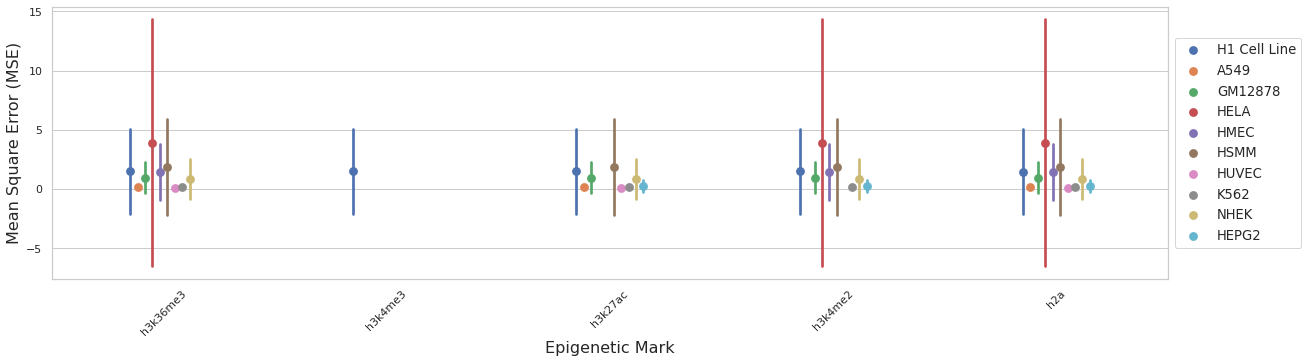

In [9]:
#plot
import seaborn as sns
sns.set(rc={'figure.figsize':(20, 5)})
#sns.set_palette("colorblind")
#same wesanderson palette as used in R plots
extended_palette = ["#9A8822","#F5CDB4","#F8AFA8",
                    "#FDDDA0","#74A089","#85D4E3",
                    #added extra to make 7
                    '#78A2CC']
sns.set(font_scale = 1.2)
sns.set_style("whitegrid")

perf_plt = sns.pointplot(hue = "cell",       
            y = "mse",
            x = "assay",  
            #palette=sns.color_palette(extended_palette, 7)[2:4],
            data = losses, ci="sd",join=False,
            dodge=0.3
                      )
#perf_plt.set_title('MSE',fontsize=14)
#perf_plt.legend([],[], frameon=False)
# Put the legend out of the figure
perf_plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#perf_plt.set(ylim=(-.1, .9))
perf_plt.tick_params(axis='x', rotation=45)

perf_plt.set_xlabel('Epigenetic Mark',fontsize=16)
perf_plt.set_ylabel('Mean Square Error (MSE)',fontsize=16)
perf_plt.tick_params(labelsize=11)

In [8]:
np.mean([losses.loc[(losses['assay'] == "h3k36me3") & (losses['cell'] == "GM12878")]['mse']-losses.loc[(losses['assay'] == "h3k27ac") & (losses['cell'] == "GM12878")]["mse"]])

-9.203156999622782e-05

<AxesSubplot:xlabel='assay', ylabel='mse'>

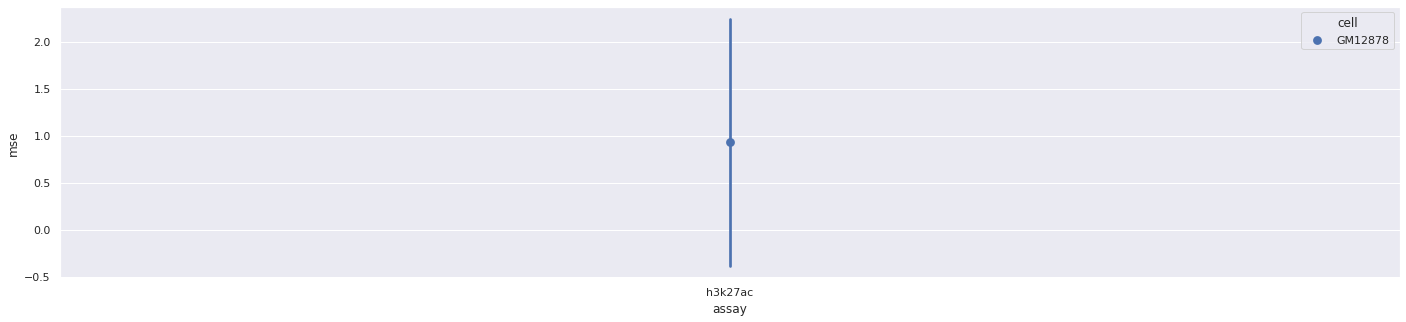

In [140]:
sns.pointplot(hue = "cell",       
            y = "mse",
            x = "assay",  
            #palette=sns.color_palette(extended_palette, 7)[2:4],
            data = losses.loc[(losses['assay'] == "h3k27ac") & (losses['cell'] == "GM12878")], ci="sd",join=False,
            dodge=0.3
                      )

